In [1]:
import addons
import numpy as np
import pandas as pd 
import os
import helpers
import random
import math
import matplotlib.pyplot as plt 
from matplotlib.patches import Polygon
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation
from scipy.signal import argrelextrema

/home/hyc_1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
import math 
from scipy.fftpack import *

def hilbert_transform(signal):
    '''
    N : fft length
    M : number of elements to zero out
    U : DFT of signal
    V: IDFT of H(U) 
    '''

    N = len(signal)
    #take the forward Fourier transform
    U = fft(signal)
    M = N - N//2 - 1
    #Zero out negative frequency components
    U[N//2+1:] = [0] * M 
    #double fft energy except #DC0
    U[1:N//2] = 2 * U[1:N//2]
    #take inverse of Fourier transform
    v = ifft(U)
    return v 

In [3]:
def analyse_synchrony(num_neurons,name,bin_width=3,t_r = 2,dt=0.01):
    analysis_interval_start = addons.analysis_dict["analysis_start"]
    analysis_interval_end = addons.analysis_dict["analysis_end"]
    analysis_interval_start_s = addons.analysis_dict["synchrony_start"]
    analysis_interval_end_s = addons.analysis_dict["synchrony_end"]
    
    
    analysis_length = analysis_interval_end - analysis_interval_start
    analysis_length_s = analysis_interval_end_s - analysis_interval_start_s
    pop_activity = {}
    if analysis_length - analysis_length_s < 0:
        print('There is a problem. Synchrony measurement range must be smaller than the other')
        return 

    sd_names, node_ids, data = helpers.__load_spike_times(name,"spike_recorder",analysis_interval_start_s, analysis_interval_end_s)
    
    helper = np.loadtxt(name+"measurements/pop_activities/pop_activity_"+str(0)+".dat")
    sum_array = np.zeros_like(helper)
    for i in range(len(num_neurons)):
        pop_activity[i] = np.loadtxt(name+"measurements/pop_activities/pop_activity_"+str(i)+".dat")
        sum_array = sum_array + pop_activity[i]

    data_s = {}

    for i in data:
        low = np.searchsorted(data[i]["time_ms"],v=analysis_interval_start_s,side="left")
        high = np.searchsorted(data[i]["time_ms"],v=analysis_interval_end_s,side='right')
        data_s[i] = data[i][low:high]


    synchrony_pd = []
    synchrony_chi = []
    irregularity = []
    irregularity_pdf = {}

    super_lvr = []
    lvr_pdf = {}

    times_s = {}

    for i, n in enumerate(sd_names):

        #Computing synchrony
        neurons = np.unique(data_s[i]["sender"])
        random.shuffle(neurons)
        chosen_ones = neurons[1:1000]
        indices = []
        for indx in chosen_ones:
            indices = np.append(indices,np.where(data_s[i]["sender"]==indx))
        indices = np.array(indices,dtype=int)
        times_s[i] = data_s[i][indices]["time_ms"]
        counts, bins = np.histogram(times_s[i], bins=int(analysis_length_s/bin_width))
        counts2, bins = np.histogram(times_s[i], bins=int(analysis_length_s/bin_width/2))
    
        synchrony_chi = np.append(synchrony_chi,np.var(counts2)/np.mean(counts2)) 
        synchrony_pd = np.append(synchrony_pd,np.var(counts)/np.mean(counts))

        #Computing irregularity and LvR
        single_irregularity = []
        used_senders = []
        single_lvr = 0
        lvr = []

    mean_pop = sum_array / len(num_neurons)
    sum = 0
    for i, n in enumerate(pop_activity):
        sum = sum + np.var(pop_activity[i])
    chi = np.var(mean_pop) / ((1 / len(num_neurons)) * sum)

    
    for i,n in enumerate(sd_names):
        single_irregularity = []
        used_senders = []
        single_lvr = 0
        lvr = []
        for senders in data[i]["sender"]:
            individual_neurons = []
            times = []
            isi = []
            count = 0
            if senders not in used_senders:
                used_senders = np.append(used_senders,senders)
                individual_neurons = np.append(individual_neurons,np.where(data[i]["sender"]==senders))
                for index in individual_neurons:
                    times = np.append(times,data[i][int(index)]["time_ms"])

                if len(times)>4:
                    for j in range(len(times)-1):
                        isi = np.append(isi,times[j+1]-times[j])
                    for j in range(len(isi)-1):
                        single_lvr = single_lvr +  (1 - 4*isi[j]*isi[j+1] / (isi[j]+isi[j+1])**2) * (1 + 4 * t_r / (isi[j] + isi[j+1]))

                    neuron_rate = len(times) / analysis_length * 1000

                    single_lvr = 3 / (len(isi)-1) * single_lvr
                    lvr = np.append(lvr, single_lvr)
                    mean =np.mean(isi)
                    var = np.sqrt(np.var(isi))
                    single_irregularity = np.append(single_irregularity,np.float128(var/mean))
                    count = count + 1


        super_lvr = np.append(super_lvr, np.mean(lvr))
        
        lvr_pdf[i] = lvr
        if np.mean(single_irregularity)==None:
            irregularity = np.append(irregularity,0)
        else:
            irregularity = np.append(irregularity,np.mean(single_irregularity))
        irregularity_pdf[i] = single_irregularity
        if count >= 1000:
            break
    
    #super_lvr = super_lvr[~np.isnan(super_lvr)]
    #irregularity = irregularity[~np.isnan(irregularity)] 
 
    return synchrony_pd, synchrony_chi, irregularity, irregularity_pdf, super_lvr, lvr_pdf, times_s, chi 


In [4]:
def plot_synchrony(synchrony_pd, synchrony_chi, irregularity, irregularity_pdf, lvr, lvr_pdf,chi, name):

    a = plt.figure(figsize=(18,18))

#####################################################################################################################
    pops = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
    colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    fs = 18
    medianprops = dict(linestyle="-", linewidth=2.5, color="black")
    meanprops = dict(linestyle="--", linewidth=2.5, color="darkgray")

    plt.subplot(3, 2, 1)
    plt.barh(pops[::-1], synchrony_pd[::-1], color = colours[::-1])
    plt.xlabel('synchrony', fontsize = fs)
    plt.grid(alpha = 0.5)

#####################################################################################
    plt.subplot(3, 2, 2)
    plt.barh(pops[::-1], synchrony_chi[::-1], color = colours[::-1])
    #plt.ylabel('populations', fontsize = fs)
    plt.title(r'$\chi$ =('+str(round(chi,3))+')', fontsize = fs)
    plt.xlabel('synchrony with half bin size', fontsize = fs)
    plt.grid(alpha = 0.5)


###########################################################################################################################
    plt.subplot(3,2,3)
    test = []
    colours_box = ['#3288bd','#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    pops_box = pops
    label_pos = list(range(len(pops_box),0,-1))
    for i in np.arange(len(pops)):
        if len(irregularity_pdf[i]) == 0: 
            del pops_box[i]
        else:
            test.append(irregularity_pdf[i])
    bp = plt.boxplot(test, 0, "rs",0,medianprops=medianprops,meanprops=meanprops, meanline=True, showmeans=True,orientation='horizontal')
    label_pos = list(range(len(pops_box), 0, -1))
    if len(pops) != len(pops_box):
        colours_box = ['#3288bd', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    for i in np.arange(len(pops_box)):
        boxX = []
        boxY = []
        box = bp["boxes"][i]
        for j in list(range(5)):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        boxCoords = list(zip(boxX, boxY))
        boxPolygon = Polygon(boxCoords, facecolor=colours_box[-i])
        plt.gca().add_patch(boxPolygon)
    plt.xlabel('irregulatiry', fontsize = fs)
    plt.yticks(label_pos, pops_box, fontsize=fs)
    plt.grid(alpha = 0.5)

############################################################################################################
    plt.subplot(3,2,4)
    pops = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
    colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    colours_pdf = list(reversed(colours))
    pops_pdf = list(reversed(pops))
    irregularity_total = []
    for i in irregularity_pdf:
        data, bins= np.histogram(irregularity_pdf[i],density=True,bins=50)
        irregularity_total = np.append(irregularity_total,irregularity_pdf[i])
        plt.plot(bins[:-1],data,alpha=0.3+i*0.1, label = pops_pdf[i], color = colours_pdf[i])

    data_t, bins_s = np.histogram(irregularity_total,density=True,bins=50)
    plt.plot(bins[:-1],data_t, label = 'Total', color = 'black', ls = 'dashed')
   
    plt.legend()
    plt.ylabel('P (irregularity)', fontsize = fs)
    plt.xlabel('CV ISI', fontsize = fs)
    plt.grid(alpha = 0.5)
    plt.xlim(0,1.8)
    plt.ylim(0,3.6)

######################################################################################################################
    plt.subplot(3,2,5)
    
    colours_box = ['#3288bd','#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    pops_box = pops
    test = []
    for i in np.arange(len(pops)):
        if len(lvr_pdf[i]) == 0: 
            del pops_box[i]
        else:
            test.append(lvr_pdf[i])
    bp = plt.boxplot(test, 0, "rs",0,medianprops=medianprops,meanprops=meanprops, meanline=True, showmeans=True,orientation='horizontal')
    if len(pops) != len(pops_box):
        colours_box = ['#3288bd', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    label_pos = list(range(len(pops_box), 0, -1))
    for i in np.arange(len(pops_box)):
        boxX = []
        boxY = []
        box = bp["boxes"][i]
        for j in list(range(5)):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        boxCoords = list(zip(boxX, boxY))
        k = i % 2
        boxPolygon = Polygon(boxCoords, facecolor=colours_box[-i])
        plt.gca().add_patch(boxPolygon)
    #plt.title('LvR')
    plt.yticks(label_pos, pops_box, fontsize=fs)
    plt.xlabel('LvR', fontsize = fs)
    plt.grid(alpha = 0.5)

##########################################################################################################################################
    plt.subplot(3,2,6)
    lvr_total = []
    for i in lvr_pdf:
        data, bins= np.histogram(lvr_pdf[i],density=True)
        lvt_total = np.append(lvr_total,lvr_pdf[i])
        if math.isnan(data[0]) == False:
            plt.plot(bins[:-1],data,alpha=0.3+i*0.1, label = pops_pdf[i], color = colours_pdf[i])

    data_t, bins_s = np.histogram(lvr_total,density=True)
    plt.plot(bins[:-1],data_t, label = 'Total', color = 'black', ls = 'dashed')
    plt.grid(alpha = 0.5)
    plt.legend()
    plt.ylabel('P (LvR)', fontsize = fs)
    #plt.title('P (LvR)')
    plt.xlim(0,8)
    plt.ylim(0,2.1)
    plt.xlabel('LvR', fontsize =fs)

    if os.path.isdir(name) == False:
        os.mkdir(name)
        
    plt.suptitle(str(name))
    plt.tight_layout()
    plt.savefig(name + "test_synchrony.svg", dpi=300)
    plt.show()



In [5]:
path = 'stimulation/data_pulse_packet_example/'
pop_activity = {}
names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

       
neuron_id = np.loadtxt((os.path.join(path,"population_nodeids.dat")),dtype=int)
num_neurons = []
for l in range(len(neuron_id)):
    num_neurons = np.append(num_neurons,int(neuron_id[l][1]-neuron_id[l][0]+1))
num_neurons = num_neurons.astype(int)
pop_activity = {}
times = {}
for j in range(len(num_neurons)):
    pop_activity[j] = np.loadtxt(path+"/measurements/pop_activities/pop_activity_"+str(j)+".dat")
    times[j] = np.loadtxt(path+"/measurements/times/times_"+str(j)+".dat")

In [6]:
voltage_data = addons.load_data(path,"voltmeter")

In [7]:
time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
#time_data = addons.get_time(voltage_data,num_neurons[0]) 
data_pop = {}
names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
for i in range(len(num_neurons)):
    data_pop[i] = addons.split_data(voltage_data[i], num_neurons[i])

del(voltage_data)
data_voltages, times_3, times_help = addons.prepare_data(data_pop)
data_voltages_2 = {}

for i, n in enumerate(data_voltages):
    data_voltages_2[i] = data_voltages[n] - np.mean(data_voltages[n])

In [8]:
def filter_signal(data,fs,lowcut,highcut,order=3):

    return addons.butter_bandpass_filter(data,lowcut,highcut,fs,order)

In [9]:
###### filter the signal in gamma, for example

lowcut_gamma = 50
highcut_gamma = 95
pop_signal_gamma = {}
volt_signal_gamma = {}

for i in range(len(pop_activity)):
    pop_signal_gamma[i] = filter_signal(pop_activity[i],fs=1000,lowcut=lowcut_gamma,highcut=highcut_gamma)
    volt_signal_gamma[i] =  filter_signal(data_voltages_2[i],fs=1000,lowcut=lowcut_gamma,highcut=highcut_gamma)


lowcut_alpha = 8
highcut_alpha =12
pop_signal_alpha = {}
volt_signal_alpha = {}

for i in range(len(pop_activity)):
    pop_signal_alpha[i] = filter_signal(pop_activity[i],fs=1000,lowcut=lowcut_alpha,highcut=highcut_alpha)
    volt_signal_alpha[i] =  filter_signal(data_voltages_2[i],fs=1000,lowcut=lowcut_alpha,highcut=highcut_alpha)



In [10]:
##### Obtain the hilbert transform of both the voltages and the population activity


pop_activity_hilbert_gamma = {}
voltages_hilbert_gamma = {}
for i in range(len(pop_activity)):
    pop_activity_hilbert_gamma[i] = hilbert_transform(pop_signal_gamma[i])
    voltages_hilbert_gamma[i] = hilbert_transform(volt_signal_gamma[i])

Text(0, 0.5, 'voltage minus de mean (mV)')

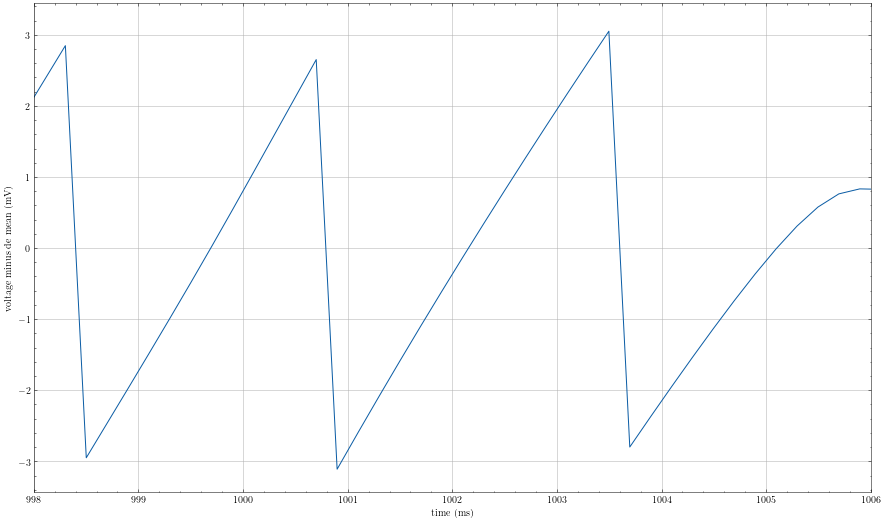

In [11]:

plt.figure(figsize=(15,9))
for i in range(len(pop_activity_hilbert_gamma)):
    if i == 3:
        plt.plot(times[i][1::], np.angle(pop_activity_hilbert_gamma[i]))
plt.grid()
plt.xlabel('time (ms)')
plt.xlim(998,1006)
plt.ylabel('voltage minus de mean (mV)')

In [23]:
pop_test

array([-2.92757751, -2.40335249, -1.90014046, -1.41536854, -0.94643768,
       -0.49071067, -0.04566449,  0.39142258,  0.82302184,  1.25157779,
        1.67907069,  2.10700058,  2.53629895])

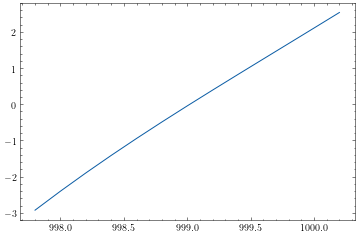

In [21]:
times_test = times[4][489:502]
pop_test = np.angle(pop_activity_hilbert_gamma[4][489:502])
amp_test = np.abs(pop_activity_hilbert_gamma[4][489:502])
times_2 = times[4][489:502]
plt.plot(times_test,pop_test)

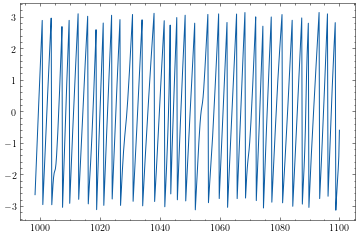

In [79]:
times_test = times[4][491::]
pop_test = np.angle(pop_activity_hilbert_gamma[4][490::])
amp_test = np.abs(pop_activity_hilbert_gamma[4][530::])
times_2 = times[4][531::]
plt.plot(times_test,pop_test)

In [80]:
mins = argrelextrema(pop_test,np.less)

In [82]:
mins[0][1], mins[0][2]

(28, 46)

In [63]:
phase_delay = times_test[mins[0][2]]
period = times_test[mins[0][1]] - times_test[mins[0][0]]

In [56]:
time_array = times_test[mins[0][0]:mins[0][1]+1]
phase_array = pop_test[mins[0][0]:mins[0][1]+1]

In [57]:
time_array

array([ 998.4,  998.6,  998.8,  999. ,  999.2,  999.4,  999.6,  999.8,
       1000. , 1000.2, 1000.4, 1000.6, 1000.8, 1001. , 1001.2])

In [58]:
phase_array

array([-2.98479532, -2.51645052, -2.05010853, -1.5864665 , -1.12619071,
       -0.66997717, -0.21834369,  0.22859127,  0.67100583,  1.10917755,
        1.54340655,  1.97406281,  2.40157844,  2.8262626 , -3.03527371])

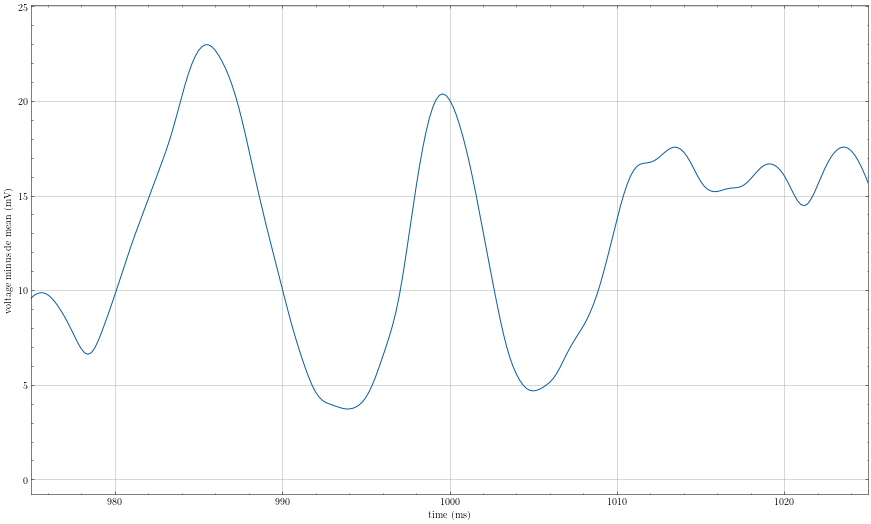

In [64]:

plt.figure(figsize=(15,9))
for i in range(len(pop_activity_hilbert_gamma)):
    if i == 3:
        plt.plot(times[i][1::], np.abs(pop_activity_hilbert_gamma[i]))
plt.xlim(975,1025)
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('voltage minus de mean (mV)')
plt.show()

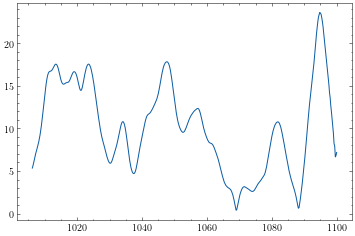

In [74]:
plt.plot(times_2,amp_test)

In [75]:
max = amp_test[argrelextrema(amp_test,np.greater)[0][0]]

In [76]:
max

17.55282070307324

In [ ]:

plt.figure(figsize=(15,9))
for i in range(len(pop_activity_hilbert_gamma)):
    if i == 3:
        plt.plot(times[i][1::], np.angle(pop_activity_hilbert_gamma[i]))
plt.xlim(975,1025)
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('voltage minus de mean (mV)')
plt.show()
plt.figure(figsize=(15,9))
for i in range(len(pop_activity_hilbert_gamma)):
    if i ==3:
        plt.plot(times[i][1::], np.angle(voltages_hilbert_gamma[i]))
plt.xlim(975,1025)
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('voltage minus de mean (mV)')
plt.show()

In [ ]:

plt.figure(figsize=(15,9))
for i in range(len(pop_activity_hilbert_gamma)):
    if i == 3:
        plt.plot(times[i][1::], np.abs(pop_activity_hilbert_gamma[i]))
plt.xlim(975,1025)
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('voltage minus de mean (mV)')
plt.show()
plt.figure(figsize=(15,9))
for i in range(len(pop_activity_hilbert_gamma)):
    if i ==3:
        plt.plot(times[i][1::], np.abs(voltages_hilbert_gamma[i]))
plt.xlim(975,1025)
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('voltage minus de mean (mV)')
plt.show()

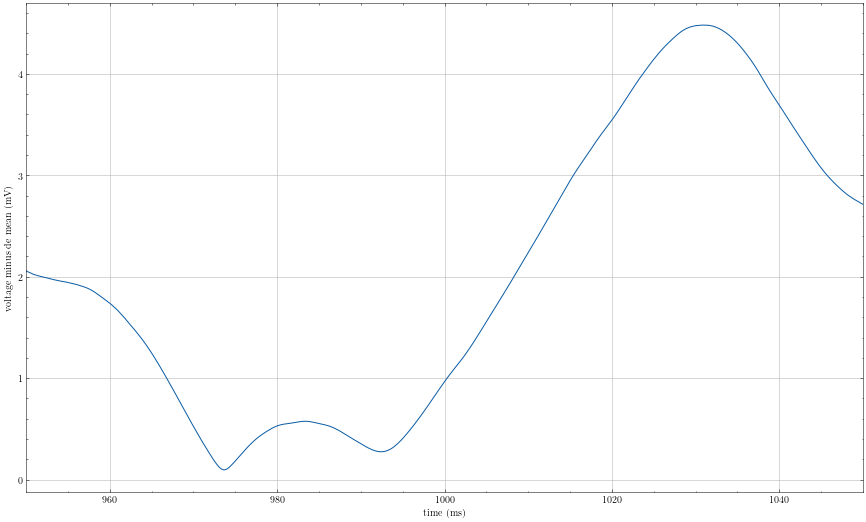

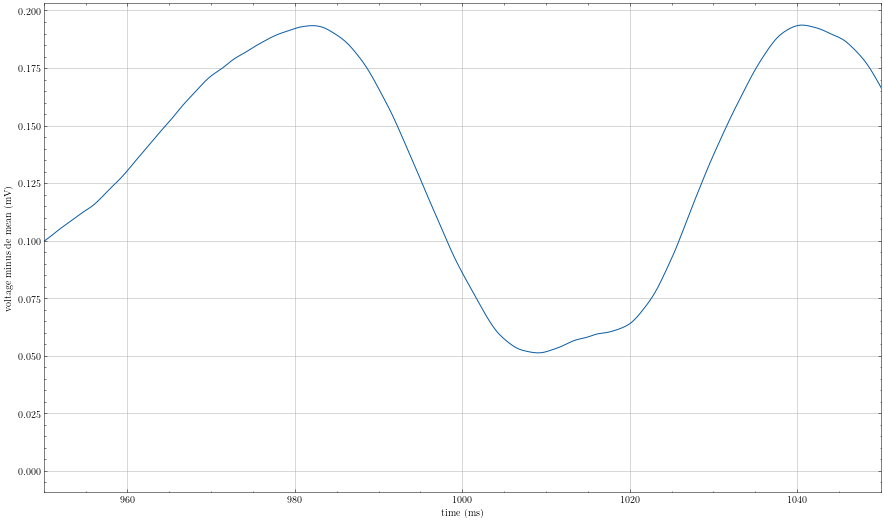

In [27]:
##### Obtain the hilbert transform of both the voltages and the population activity


pop_activity_hilbert_alpha = {}
voltages_hilbert_alpha = {}
for i in range(len(pop_activity)):
    pop_activity_hilbert_alpha[i] = hilbert_transform(pop_signal_alpha[i])
    voltages_hilbert_alpha[i] = hilbert_transform(volt_signal_alpha[i])

    
plt.figure(figsize=(15,9))
for i in range(len(pop_activity_hilbert_alpha)):
    if i == 3:
        plt.plot(times[i][1::], np.abs(pop_activity_hilbert_alpha[i]))
plt.xlim(950,1050)
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('voltage minus de mean (mV)')
plt.show()

plt.figure(figsize=(15,9))
for i in range(len(pop_activity_hilbert_alpha)):
    if i ==3:
        plt.plot(times[i][1::], np.abs(voltages_hilbert_alpha[i]))
plt.xlim(950,1050)
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('voltage minus de mean (mV)')
plt.show()